# Algorithmic Bias Machine Learning with Python Assignment 1

Daniel Cosgrave - 16302163

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, load_boston, make_moons
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier, \
    GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from collections import Counter
from sklearn.model_selection import *
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from sklearn.decomposition import PCA
from scipy.stats import reciprocal, uniform
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [2]:
surv = pd.read_csv('survival.csv')
surv.head()
surv['Class'].value_counts()

1    225
2     81
Name: Class, dtype: int64

In [3]:
y = surv.pop('Class').values
X = surv.values
X.shape
y.shape
MinorityClass = (Counter(y)[2]/len(y))
print("Minority class : %0.2f" %MinorityClass)

Minority class : 0.26


Class:

1 = Greater than 5 Year Survival Rate
2 = Less than 5 Year Survival Rate

## $k$-NN Adjustment
2 is the minority class at ~26%.
$k$-NN classifier picks up this under-representation and accentuates it

To evaluate the optimal number of neighbours to use it is useful to evaluate a nearest neighbours
classifier with different numbers of neighbours. Here I will test 1-5 neighbours and see what is roughly the best
to start looking at the bias.

In [4]:
testSet = 5
#y_pred = []
i=0
#accuracy = np.array([testSet])
accuracy = []
precision = []
recall = []
F1 = []
counts = []
best = 0
#X = StandardScaler().fit_transform(X)   #Normalise Data
while i < testSet:
    kNN = KNeighborsClassifier(n_neighbors=i+1, weights = 'distance')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
    y_pred = kNN.fit(X_train, y_train).predict(X_test)
    counts = Counter(y_pred)
    confM = confusion_matrix(y_test, y_pred)
    tp = confM[0,0]
    fn = confM[0,1]
    fp = confM[1,0]
    tn = confM[1,1]
    accuracy = ((tp+tn)/(tp+fn+fp+tn))
    precision = (tp/(tp+fp))
    recall = (tp/(tp+fn))
    auc = roc_auc_score(y_test, y_pred)
    pred_neg = Counter(y_pred)[2]
    test_neg = Counter(y_test)[2]
    minCl = pred_neg/len(y_test)
    testCl = test_neg/len(y_test)#Could change this
    tempBest = (accuracy + precision + recall + auc)/4-np.abs(minCl-testCl)
    print('Nearest Neighbours:', i+1, ' Accuracy: %0.2f' %accuracy, ' Precision: %0.2f' %precision, 'Recall: %0.2f' %recall, 'AUC: %0.2f' %auc, 'Minority Class: %0.2f' %minCl)
    if tempBest >= best:
        best = tempBest
        vals = [i+1,accuracy,precision,recall,auc,minCl]
    i = i + 1
print('Best Nearest Neighbours:  ', vals[0], ' Accuracy:  %0.2f' %vals[1], ' Precision: %0.2f' %vals[2], 'Recall: %0.2f' %vals[3], 'AUC: %0.2f' %vals[4])
print('Predicted Minority Class: %0.2f' %vals[5])

Nearest Neighbours: 1  Accuracy: 0.66  Precision: 0.76 Recall: 0.76 AUC: 0.59 Minority Class: 0.29
Nearest Neighbours: 2  Accuracy: 0.66  Precision: 0.75 Recall: 0.80 AUC: 0.56 Minority Class: 0.23
Nearest Neighbours: 3  Accuracy: 0.68  Precision: 0.74 Recall: 0.84 AUC: 0.55 Minority Class: 0.19
Nearest Neighbours: 4  Accuracy: 0.68  Precision: 0.74 Recall: 0.84 AUC: 0.55 Minority Class: 0.19
Nearest Neighbours: 5  Accuracy: 0.69  Precision: 0.75 Recall: 0.85 AUC: 0.56 Minority Class: 0.18
Best Nearest Neighbours:   1  Accuracy:  0.66  Precision: 0.76 Recall: 0.76 AUC: 0.59
Predicted Minority Class: 0.29


. The theory being Lower K = Less Biased, more inaccurate, higher K = more biased, less inaccurate

By this method it would be equally viable to choose either either k = 1, 3, or 5 based on the classification need

The best accuracy/Minority Classification tradeoff is k = 1, however judging by its low accuracy it quite inaccurately chooses the minority class too often

## 1 Hold-Out Testing
I tested multiple train/test splits for bias

Scoring Metrics

Accuracy - How accurate overall is the classifier

Relative Minority - Predicted Minority / Test Set Minority, how biased is it

Area under the curve (AUC) - The area under the false positive rate, true positive rate curve, i.e how often,
when the classifier chooses a minority or majority class, is it correct (I scaled this from 0-1 to 0-100
to look right with the other scores)

In [5]:
names = ["Nearest Neighbors",
         "Decision Tree",
         "Logistic Regression",
         "Gradient Boosting"]

classifiers = [
    KNeighborsClassifier(n_neighbors=vals[0], weights = 'distance'),
    DecisionTreeClassifier(),
    LogisticRegression(solver='lbfgs'),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=1)]

In [6]:
split = np.arange(1/16,1,1/16)
score = []
scores = []
minCl = []
testCl = []
minorityClassRelative = []
relativeCl = []
aocScore = []
aocScores = []
h = 0.2
i = 0

for name, classifier in zip(names, classifiers):
    j=0
    for j in split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = j, random_state=42)
        y_pred = classifier.fit(X_train, y_train).predict(X_test)
        score.append(accuracy_score(y_test,y_pred))
        aocScore.append(roc_auc_score(y_test,y_pred))
        pred_neg = Counter(y_pred)[2]
        test_neg = Counter(y_test)[2]
        minCl = pred_neg/len(y_test)
        testCl = test_neg/len(y_test)
        relativeCl.append(minCl/testCl)
    minorityClassRelative.append(relativeCl)
    scores.append(score)
    aocScores.append(aocScore)
    relativeCl = []
    score = []
    minCl = []
    testCl = []
    aocScore = []
    i = i + 1

In [7]:
N = len(scores)
i = 0
#Percentages
PercentageScores = []
PercentageMinorityClassRelative = []
for row in scores:
    PercentageScores.append([i*100 for i in row])
for row in minorityClassRelative:
    PercentageMinorityClassRelative.append([i*100 for i in row])

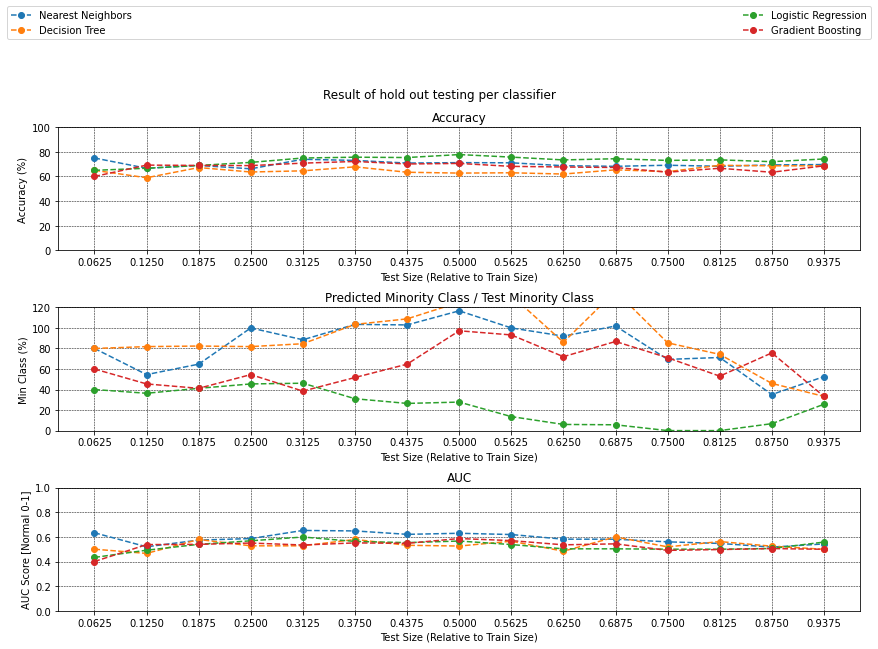

In [8]:
fig, axs = plt.subplots(3, figsize=(12, 8))
fig.suptitle('Result of hold out testing per classifier')
while i < N:
    axs[0].plot(split, PercentageScores[i],'o--', linewidth = 1.5)
    axs[1].plot(split, PercentageMinorityClassRelative[i],'o--', linewidth = 1.5)
    axs[2].plot(split,aocScores[i],'o--', linewidth = 1.5)
    i = i + 1
axs[0].set_xlabel('Test Size (Relative to Train Size)')
axs[1].set_xlabel('Test Size (Relative to Train Size)')
axs[2].set_xlabel('Test Size (Relative to Train Size)')
axs[0].set_ylim(0,100)
axs[1].set_ylim(0,120)
axs[2].set_ylim(0,1)
axs[0].set_ylabel('Accuracy (%)')
axs[1].set_ylabel('Min Class (%)')
axs[2].set_ylabel('AUC Score [Normal 0-1]')
axs[0].set_title('Accuracy')
axs[1].set_title('Predicted Minority Class / Test Minority Class')
axs[2].set_title('AUC')
axs[0].set_xticks(split)
axs[1].set_xticks(split)
axs[2].set_xticks(split)
axs[0].grid(color='black', linestyle='--', linewidth=0.5)
axs[1].grid(color='black', linestyle='--', linewidth=0.5)
axs[2].grid(color='black', linestyle='--', linewidth=0.5)
fig.legend(names, bbox_to_anchor=(0., 1.02, 1., .102), loc='upper left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout(h_pad = 1)
plt.show()

The least biased hold out test for nearest neighbours and decision trees was a test size of 37.5%, and gradient boosting improved greatly from 0.375 to 0.5. Though logistic regression had similar (low) accuracy and AUC score to the rest of the classifiers, it had the worst bias performance.

## Cross Validation
Using 12-fold cross validation because my CPU has 12 threads

In [9]:
score.clear()
minCl = []
testCl = []
relativeCl = []
aocScore = []
N = len(classifiers)
Nrange = np.arange(N)
PercentageScores.clear()
PercentageMinorityClassRelative.clear()
i = 0
best = 0
for name, classifier in zip(names, classifiers):
    y_pred = cross_val_predict(classifier,X, y,cv=12)
    #print(y_pred)
    score.append(accuracy_score(y,y_pred))
    aocScore.append(roc_auc_score(y,y_pred))
    pred_neg = Counter(y_pred)[2]
    test_neg = Counter(y)[2]
    minCl = pred_neg/len(y)
    testCl = test_neg/len(y)
    relativeCl.append(minCl/testCl)
    i = i + 1

In [10]:
#I feel there must be a better way to do this...
temp = []
for i in score:
    temp.append([i*100])
flat_Scores = []
for sublist in temp:
    for item in sublist:
        flat_Scores.append(item)
temp = []
for i in relativeCl:
    temp.append([i*100])
flat_relativeCls = []
for sublist in temp:
    for item in sublist:
        flat_relativeCls.append(item)
temp = []
for i in aocScore:
    temp.append([i*100])
aocScoreScaled = []
for sublist in temp:
    for item in sublist:
        aocScoreScaled.append(item)

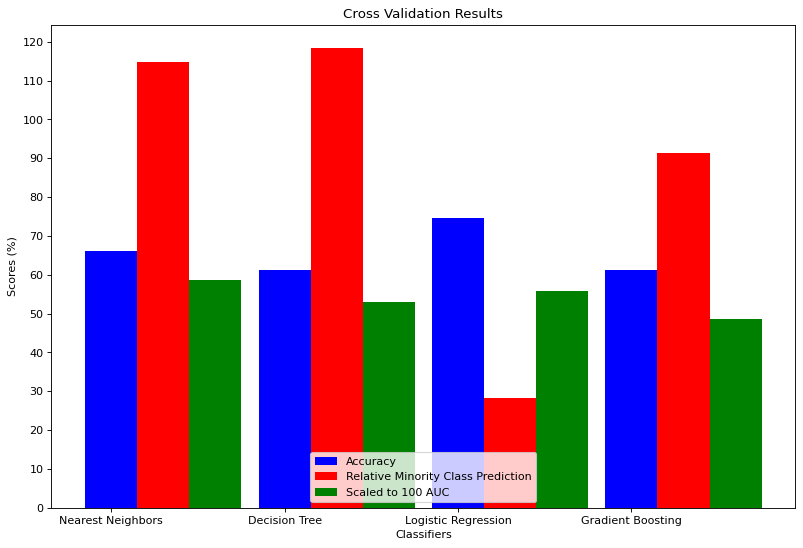

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
width = 0.3
fig.suptitle('Result of cross validation')
plt.bar(Nrange, flat_Scores, width, color = 'blue')
plt.bar(Nrange+width, flat_relativeCls, width, label = names, color = 'red')
plt.bar(Nrange+2*width, aocScoreScaled, width, color = 'green')
plt.xlabel('Classifiers')
plt.ylabel('Scores (%)')
plt.legend(['Accuracy','Relative Minority Class Prediction','Scaled to 100 AUC'],loc='lower center')
plt.title('Cross Validation Results')
plt.xticks(Nrange, names)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100,110,120])
plt.show()
plt.tight_layout()

Cross Validation resulted in a lower overall bias in the results, though it actually tipped the decision trees
classifier over the top, resulting in it classifying almost 120% of the minority class, implying that perhaps cross validation is a good way to avoid bias without having to search for the right hold out test

Most interestingly about logistic regression was that it maintained a high
AUC score despite its high bias, showing that at least when it did choose a minority class it was choosing
at least as well as the other classifiers

Overall the least biased classifier were the decision tree classifiers,
these results would lead me to my proposed solution

## 2 Proposed Solution
Random Forest and Gradient Boosting Decision Tree Ensemble Classification with SMOTE Up-sampling and
Edited Nearest Neighbours (ENN) Down-sampling using the imbalanced learn functions in sklearn


Final Classifier will be a stacked Forest of Decision Trees with a Support Vector Machine which will
output their final predictions into a Logistic Regression model - Wolpert, David H. “Stacked generalization.” Neural networks 5.2 (1992)

I decided not to under-sample the majority class as the dataset is quite small

Decision tree classifiers are good at compensating for underrepresented classes in datasets, especially
ensemble decision trees I compared using ensemble decision tree classifiers (random forest and gradient boosting)
 against the other classifiers in the previous section, with fixed hold-out testing, and also against themselves
 when using unsampled data versus the data resampling techniques above

SMOTE over-samples the minority class, and ENN resamples the majority class by removing outliers that are not near any
minority class examples

Using cross validation would probably have improved these results, however it would have greatly increased the
processing time

In [12]:
#The nice thing about the way I set up here is I can add classifiers and names easily and they will automatically plot

classifiers = [DecisionTreeClassifier(max_depth=None, criterion = 'entropy'),
               GradientBoostingClassifier(n_estimators=100, max_depth=None,
                                          min_samples_split=2, min_samples_leaf=1),
               RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None,
                                          min_samples_split=2, min_samples_leaf=1, n_jobs = -1),
               make_pipeline(StandardScaler(), SVC(C = 0.5, kernel='linear'))] #Setting n_jobs to -1 allows for maximum multithreading performance I believe
names = ["Single Tree",
         "Gradient Boosting",
         "Random Forest",
         "Support Vector"]

#sv = make_pipeline(StandardScaler(), SVC(random_state=2))
clf = list(zip(names,classifiers))
stack = StackingClassifier(estimators=clf, final_estimator=LogisticRegression())

classifiers.append(stack)
names.append("Stacking")

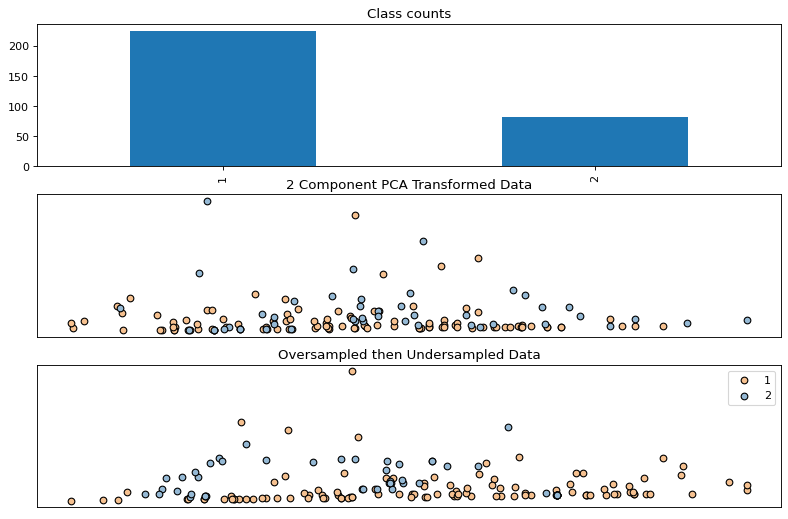

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42)
cm = ['#f6c190', '#95b9d5']
df = pd.DataFrame(X)
df['Class'] = y
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(3,1,1)
df.Class.value_counts().plot(kind='bar', title='Class counts')
markers = ['o', 'o']
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X_train)
plt.subplot(3,1,2)
for l, c, m in zip(np.unique(y), cm, markers):
    plt.scatter(
        X_PCA[y_train==l, 0],
        X_PCA[y_train==l, 1],
        c=c, label=l, marker=m, edgecolors='k'
    )
plt.title('2 Component PCA Transformed Data')
plt.xticks(())
plt.yticks(())
smt = SMOTE(sampling_strategy='auto',random_state=2)
enn = EditedNearestNeighbours(sampling_strategy='auto')
X_smt, y_smt = smt.fit_sample(X_train, y_train)
X_smt, y_smt = enn.fit_sample(X_smt, y_smt)
CA = pca.fit_transform(X_smt)
X_PCA = pca.fit_transform(X_smt)
plt.subplot(3,1,3)
for l, c, m in zip(np.unique(y), cm, markers):
    plt.scatter(
        X_PCA[y_smt==l, 0],
        X_PCA[y_smt==l, 1],
        c=c, label=l, marker=m, edgecolors='k'
    )
plt.xticks(())
plt.yticks(())
plt.title('Oversampled then Undersampled Data')
plt.legend(loc='upper right')
plt.show()

In [14]:
score = []
aocScore = []
relativeCl = []
relativeCl_new = []
score_new = []
aocScore_new = []
#Train on scaled data, test on unscaled data
#y_test_smt and X_test_smt will not be used
for name, classifier in zip(names, classifiers):
    #Calculate the unsampled data
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    score.append(accuracy_score(y_test,y_pred))
    aocScore.append(roc_auc_score(y_test,y_pred))
    pred_neg = Counter(y_pred)[2]
    test_neg = Counter(y_test)[2]
    minCl = pred_neg/len(y_test)
    testCl = test_neg/len(y_test)
    relativeCl.append(minCl/testCl)

    #test on completely unseen data that has not been smt sampled
    y_pred = classifier.fit(X_smt, y_smt).predict(X_test)
    score_new.append(accuracy_score(y_test, y_pred))
    aocScore_new.append(roc_auc_score(y_test,y_pred))
    pred_neg = Counter(y_pred)[2]
    test_neg = Counter(y)[2]
    minCl = pred_neg/len(y_test)
    testCl = test_neg/len(y_test)
    relativeCl_new.append(minCl/testCl)

In [15]:
PercentageScores = []
temp = []
for i in score_new:
    PercentageScores.append([i*100])
flat_Scores_new = []
for sublist in PercentageScores:
    for item in sublist:
        flat_Scores_new.append(item)

temp = []
for i in relativeCl_new:
    temp.append([i*100])
flat_relativeCls_new = []
for sublist in temp:
    for item in sublist:
        flat_relativeCls_new.append(item)

temp = []
for i in aocScore_new:
    temp.append([i*100])
aocScoreScaled_new = []
for sublist in temp:
    for item in sublist:
        aocScoreScaled_new.append(item)

temp = []
for i in score:
    temp.append([i*100])
flat_Scores = []
for sublist in temp:
    for item in sublist:
        flat_Scores.append(item)
temp = []
for i in relativeCl:
    temp.append([i*100])
flat_relativeCls = []
for sublist in temp:
    for item in sublist:
        flat_relativeCls.append(item)
temp = []
for i in aocScore:
    temp.append([i*100])
aocScoreScaled = []
for sublist in temp:
    for item in sublist:
        aocScoreScaled.append(item)

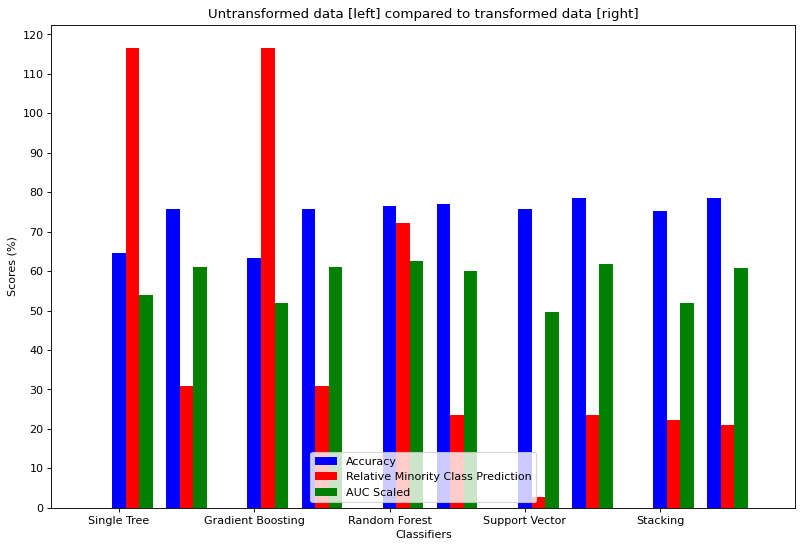

<Figure size 432x288 with 0 Axes>

In [16]:
N = len(classifiers)
Nrange = np.arange(N)
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
width = 0.1
plt.bar(Nrange, flat_Scores, width, label = names,color = 'blue')
plt.bar(Nrange+width, flat_relativeCls, width, label = names, color = 'red')
plt.bar(Nrange+2*width, aocScoreScaled, width, label = names, color = 'green')
plt.bar(Nrange+4*width, flat_Scores_new, width, label = names,color = 'blue')
plt.bar(Nrange+5*width, flat_relativeCls_new, width, label = names, color = 'red')
plt.bar(Nrange+6*width, aocScoreScaled_new, width, label = names,color = 'green')
plt.legend(['Accuracy','Relative Minority Class Prediction', 'AUC Scaled' ],loc='lower center')
#plt.hlines(np.max(flat_Scores),-1,N+1,linestyle='--', linewidth = 0.5)
plt.xlim([-0.5,N])
plt.xlabel('Classifiers')
plt.ylabel('Scores (%)')
plt.title('Untransformed data [left] compared to transformed data [right]')
plt.xticks(Nrange, names)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100, 110, 120])
plt.show()
plt.tight_layout()

In [17]:
i = 0
print("Proportion of Minority Class in Data: %0.2f" %MinorityClass) #The random sampling for the test data should be analogous to the real data
while i < len(classifiers)-1:
    relativeCl[i] = relativeCl[i]*MinorityClass
    relativeCl_new[i] =  relativeCl_new[i]*MinorityClass
    print("Minority Class ", names[i], " (unchanged data) = %0.04f" %relativeCl[i]," (Transformed Data) = %0.04f" %relativeCl_new[i])
    i = i + 1

Proportion of Minority Class in Data: 0.26
Minority Class  Single Tree  (unchanged data) = 0.3088  (Transformed Data) = 0.0817
Minority Class  Gradient Boosting  (unchanged data) = 0.3088  (Transformed Data) = 0.0817
Minority Class  Random Forest  (unchanged data) = 0.1912  (Transformed Data) = 0.0621
Minority Class  Support Vector  (unchanged data) = 0.0074  (Transformed Data) = 0.0621


The least biased classifier is a single decision tree, however it has the lowest accuracy and AUC score. Stacking
classifiers into ensembles, and further stacking the ensembles along with the support vector machine improves the
accuracy of the classifier as well as its true positive/false positive ratio (AUC). The gradient boosting classifier interestingly became more biased with the resampling, but its AUC score was improved

I was extremely surprised that upsampling the minority class and resampling the majority had almost no effect on the bias of some of the classifiers, in fact it made the single decision tree, and the gradient boosting classifier even more biased than they were. The support vector and stacking classifiers were completely ineffective at classifying untransformed data and predicted no minority class at all, and the performance of the random classifier was improved slightly. In all cases I was surprised that the transformation's effect only improved the accuracy somewhat and made some of the classifiers more biased. I tested multiple random states and hold out sizes and found little difference, however this strategy was effective on the synthetic data so I am interested to know whether transformation is simply not a good strategy for this particular dataset.

## 3 Generating a synthetic dataset as a difficult classification challenge
Generating a synthetic dataset gives maximum control over the challenge for the classifiers, in this case I wanted
to test the performance of the strategy I presented on a dataset with an extremely under-represented minority class (2%)


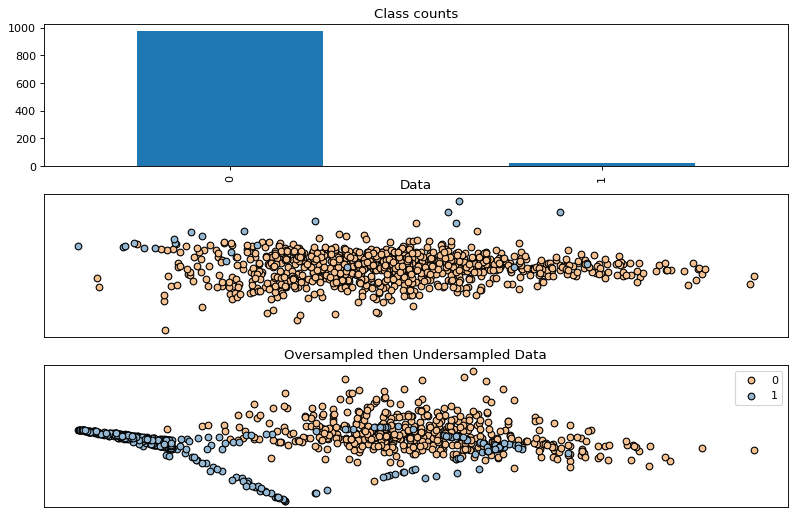

In [18]:
MajorityClass = 0.98
MinorityClass = 1-MajorityClass
Class_Weights = [MajorityClass,MinorityClass]

X,y = make_classification(n_samples=1000, n_features=4, n_informative=3, n_redundant=1, n_repeated=0, n_classes=2,
                          n_clusters_per_class=2,class_sep=1,weights=Class_Weights, random_state=2)
X = StandardScaler().fit_transform(X)
df = pd.DataFrame(X)
df['Class'] = y
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(3,1,1)
X_PCA = pca.fit_transform(X)
df.Class.value_counts().plot(kind='bar', title='Class counts')
markers = ['o', 'o']
plt.subplot(3,1,2)
for l, c, m in zip(np.unique(y), cm, markers):
    plt.scatter(
        X_PCA[y==l, 0],
        X_PCA[y==l, 1],
        c=c, label=l, marker=m,edgecolors = 'k'
    )
plt.title('Data')
plt.xticks(())
plt.yticks(())
plt.subplot(3,1,3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=2)
smt = SMOTE(sampling_strategy='auto', random_state = 2)
een = EditedNearestNeighbours(sampling_strategy='auto')
X_smt, y_smt = smt.fit_sample(X_train, y_train)
X_smt, y_smt = een.fit_sample(X_smt, y_smt)
CA = pca.fit_transform(X_smt)
X_PCA = pca.fit_transform(X_smt)
for l, c, m in zip(np.unique(y), cm, markers):
    plt.scatter(
        X_PCA[y_smt==l, 0],
        X_PCA[y_smt==l, 1],
        c=c, label=l, marker=m,edgecolors = 'k'
    )
plt.xticks(())
plt.yticks(())
plt.title('Oversampled then Undersampled Data')
plt.legend(loc='upper right')
plt.show()

score = []
minCl = []
testCl = []
relativeCl = []
aocScore = []
N = len(classifiers)
Nrange = np.arange(N)
PercentageScores.clear()
PercentageMinorityClassRelative.clear()
i = 0
score_smt = []
aocScore_smt = []
relativeCl_smt = []
for name, classifier in zip(names, classifiers):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    score.append(accuracy_score(y_test, y_pred))
    aocScore.append(roc_auc_score(y_test,y_pred))
    pred_neg = Counter(y_pred)[1]
    test_neg = Counter(y)[1]
    minCl = pred_neg/len(y_test)
    testCl = test_neg/len(y_test)
    relativeCl.append(minCl/testCl)

    #Test on the previously untouched test set
    y_pred_smt = classifier.fit(X_smt, y_smt).predict(X_test)
    score_smt.append(accuracy_score(y_test, y_pred_smt))
    aocScore_smt.append(roc_auc_score(y_test,y_pred_smt))
    pred_neg = Counter(y_pred_smt)[1]
    test_neg = Counter(y)[1]
    minCl = pred_neg/len(y_test)
    testCl = test_neg/len(y_test)
    relativeCl_smt.append(minCl/testCl)

In [19]:
#Convert to pct and flatten
temp = []
for i in score:
    temp.append([i*100])
flat_Scores = []
for sublist in temp:
    for item in sublist:
        flat_Scores.append(item)

temp = []
for i in relativeCl:
    temp.append([i*100])
flat_relativeCls = []
for sublist in temp:
    for item in sublist:
        flat_relativeCls.append(item)

temp = []
for i in aocScore:
    temp.append([i*100])
aocScoreScaled = []
for sublist in temp:
    for item in sublist:
        aocScoreScaled.append(item)

temp = []
for i in score_smt:
    temp.append([i*100])
flat_Scores_new = []
for sublist in temp:
    for item in sublist:
        flat_Scores_new.append(item)

temp = []
for i in relativeCl_smt:
    temp.append([i*100])
flat_relativeCls_new = []
for sublist in temp:
    for item in sublist:
        flat_relativeCls_new.append(item)

temp = []
for i in aocScore_smt:
    temp.append([i*100])
aocScoreScaled_new = []
for sublist in temp:
    for item in sublist:
        aocScoreScaled_new.append(item)

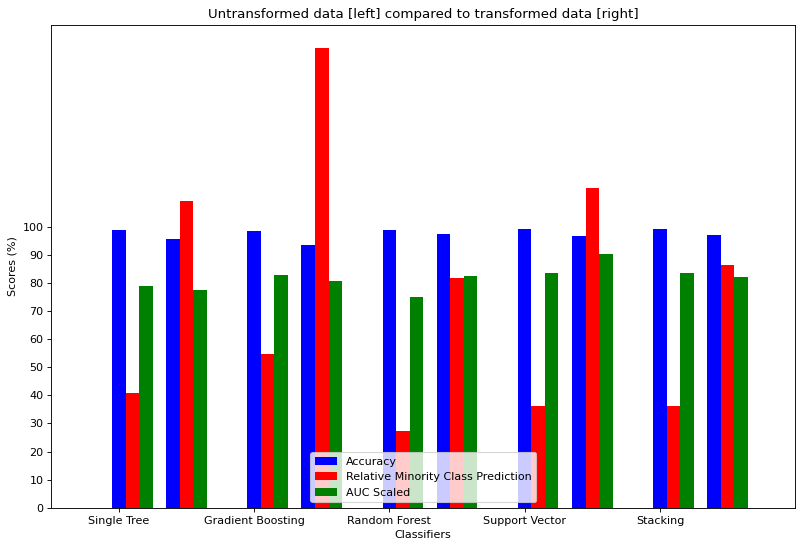

<Figure size 432x288 with 0 Axes>

In [20]:
N = len(classifiers)
Nrange = np.arange(N)
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
width = 0.1
plt.bar(Nrange, flat_Scores, width, label = names,color = 'blue')
plt.bar(Nrange+width, flat_relativeCls, width, label = names, color = 'red')
plt.bar(Nrange+2*width, aocScoreScaled, width, label = names, color = 'green')
plt.bar(Nrange+4*width, flat_Scores_new, width, label = names,color = 'blue')
plt.bar(Nrange+5*width, flat_relativeCls_new, width, label = names, color = 'red')
plt.bar(Nrange+6*width, aocScoreScaled_new, width, label = names,color = 'green')
plt.legend(['Accuracy','Relative Minority Class Prediction', 'AUC Scaled' ],loc='lower center')
#plt.hlines(np.max(flat_Scores),-1,N+1,linestyle='--', linewidth = 0.5)
plt.xlim([-0.5,N])
plt.xlabel('Classifiers')
plt.ylabel('Scores (%)')
plt.title('Untransformed data [left] compared to transformed data [right]')
plt.xticks(Nrange, names)
ytickvals = np.arange(0,110,10)
plt.yticks(ytickvals)
plt.show()
plt.tight_layout()

In [21]:
i = 0
print("Proportion of Minority Class in Data: %0.2f" %MinorityClass) #The random sampling for the test data should be analogous to the real data
while i < len(classifiers):
    relativeCl[i] = relativeCl[i]*MinorityClass
    relativeCl_smt[i] =  relativeCl_smt[i]*MinorityClass
    print("Minority Class ", names[i], " (unchanged data) = %0.04f" %relativeCl[i],
          " (Transformed Data) = %0.04f" %relativeCl_smt[i])
    i = i + 1
#print(relativeCl_smt)

Proportion of Minority Class in Data: 0.02
Minority Class  Single Tree  (unchanged data) = 0.0082  (Transformed Data) = 0.0218
Minority Class  Gradient Boosting  (unchanged data) = 0.0109  (Transformed Data) = 0.0327
Minority Class  Random Forest  (unchanged data) = 0.0055  (Transformed Data) = 0.0164
Minority Class  Support Vector  (unchanged data) = 0.0073  (Transformed Data) = 0.0227
Minority Class  Stacking  (unchanged data) = 0.0073  (Transformed Data) = 0.0173


The combination of resampling and ensembles (in combination) generally provides
improvements to classifying extremely biased data like this data with 2% minority class.
The improvement of the stacking classifier is quite minimal however, and increases processing
time greatly. By far the best classifier for the second dataset was the ensemble decision tree
gradient boosting classifier, which also performed very well in the survival dataset.

The combination of resampling and ensembles (in combination) generally provides
improvements to classifying extremely biased data like this data with 2% minority class.
The improvement of the stacking classifier is quite minimal however, and increases processing
time greatly. By far the best classifier for the second dataset was the ensemble decision tree
gradient boosting classifier, which also performed very well in the survival dataset.